In [2]:
!pip install -Uqq ipdb
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
import numpy as np
import ipdb
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Finding Historical Data From Yahoo**

In [3]:
META = yf.Ticker('META')
print(META.info)

{'address1': '1601 Willow Road', 'city': 'Menlo Park', 'state': 'CA', 'zip': '94025', 'country': 'United States', 'phone': '650 543 4800', 'website': 'https://investor.fb.com', 'industry': 'Internet Content & Information', 'industryDisp': 'Internet Content & Information', 'sector': 'Communication Services', 'sectorDisp': 'Communication Services', 'longBusinessSummary': 'Meta Platforms, Inc. engages in the development of products that enable people to connect and share with friends and family through mobile devices, personal computers, virtual reality headsets, and wearables worldwide. It operates in two segments, Family of Apps and Reality Labs. The Family of Apps segment offers Facebook, which enables people to share, discuss, discover, and connect with interests; Instagram, a community for sharing photos, videos, and private messages, as well as feed, stories, reels, video, live, and shops; Messenger, a messaging application for people to connect with friends, family, communities, an

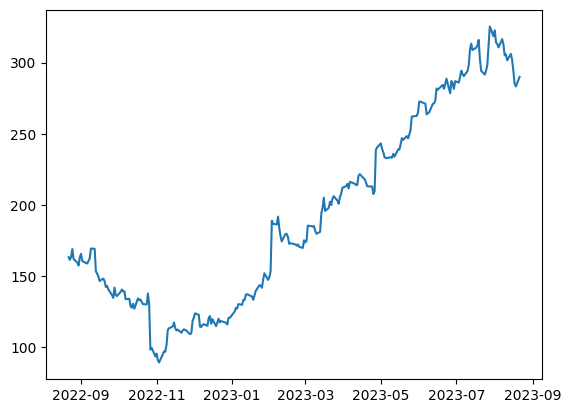

In [4]:
plt.plot(META.history(period = '1y')['Close'])

Selecting 20 Stocks with a similar P/E Ratio

In [5]:
def findStocks(names):
  stockList = []
  ratios = []
  count = 0
  for i in names:
    print(i)
    count+=1
    stock_info = yf.Ticker(i).info
    #ipdb.set_trace()

    PE = stock_info["forwardPE"]
    if PE > 20:
      if len(stockList) < 15:
        stockList.append(i)
        ratios.append(PE)
      elif PE < np.max(ratios):
        a = ratios.index(np.max(ratios))
        ratios[a] = PE
        stockList[a] = i
  return stockList

In [6]:
data= pd.read_csv("/content/gdrive/MyDrive/constituents_csv.csv")
names = data["Symbol"].tolist()
myList = findStocks(names)
print(myList)

MMM
AOS
ABT
ABBV
ABMD
ACN
ATVI
ADM
ADBE
AAP
AMD
AES
AFL
A
APD
AKAM
ALK
ALB
ARE
ALGN
ALLE
LNT
ALL
GOOGL
GOOG
MO
AMZN
AMCR
AEE
AAL
AEP
AXP
AIG
AMT
AWK
AMP
ABC
AME
AMGN
APH
ADI
ANSS
AON
APA
AAPL
AMAT
APTV
ANET
AJG
AIZ
T
ATO
ADSK
ADP
AZO
AVB
AVY
BKR
BALL
BAC
BBWI
BAX
BDX
BRK-B
BBY
BIO
TECH
BIIB
BLK
BK
BA
BKNG
BWA
BXP
BSX
BMY
AVGO
BR
BRO
BF-B
CHRW
CDNS
CZR
CPB
COF
CAH
KMX
CCL
CARR
CTLT
CAT
CBOE
CBRE
CDW
CE
CNC
CNP
CDAY
CF
CRL
SCHW
CHTR
CVX
CMG
CB
CHD
CI
CINF
CTAS
CSCO
C
CFG
CLX
CME
CMS
KO
CTSH
CL
CMCSA
CMA
CAG
COP
ED
STZ
CPRT
GLW
CTVA
COST
CTRA
CCI
CSX
CMI
CVS
DHI
DHR
DRI
DVA
DE
DAL
XRAY
DVN
DXCM
FANG
DLR
DFS
WBD
DIS
DISH
DG
DLTR
D
DPZ
DOV
DOW
DTE
DUK
PLD
DD
DXC
EMN
ETN
EBAY
ECL
EIX
EW
EA
LLY
EMR
ENPH
ETR
EOG
EFX
EQIX
EQR
ESS
EL
ETSY
RE
EVRG
ES
EXC
EXPE
EXPD
EXR
XOM
FFIV
META
FAST
FRT
FDX
FIS
FITB
FRCB
FE
FI
FLT
FMC
F
FTNT
FTV
FBIN
FOXA
FOX
BEN
FCX
GPS
GRMN
IT
GNRC
GD
GE
GIS
GM
GPC
GILD
GPN
GL
GS
HAL
HBI
HAS
HCA
PEAK
HSIC
HES
HPE
HLT
HOLX
HD
HON
HRL
HST
HWM
HPQ
HUM
HBAN
HII
IBM
IEX
IDXX
IHS

In [7]:
for i in myList:
  stock_info = yf.Ticker(i).info
  PE = stock_info["forwardPE"]
  print(i, PE)

INTC 20.456789
TT 20.497932
ORCL 20.136442
ATVI 20.524887
AMAT 20.777933
HD 20.053217
HSY 20.958334
FTV 20.614555
FCX 20.171875
RVTY 20.447037
MAR 20.944445
UNP 20.892723
AON 20.17134
BDX 20.355982
HRL 20.712765


Using an LSTM model to forecast META stock prices

In [8]:
df = yf.Ticker('META').history(period = '1y')

df= df.reset_index()
df = df[['Date', 'Close']]
df['Date'] =pd.to_datetime(df['Date']).dt.date
df.index = df.pop('Date')
df2 = df['Close'].pct_change()
df2 = df2.reset_index()
df2.drop(index=df2.index[0], axis=0, inplace=True)
df2 = df2.rename(columns={"Close": "Stock Return"})
df2.index = df2.pop('Date')
print(df)





                 Close
Date                  
2022-08-22  163.050003
2022-08-23  161.110001
2022-08-24  163.259995
2022-08-25  168.779999
2022-08-26  161.779999
...                ...
2023-08-15  301.950012
2023-08-16  294.290009
2023-08-17  285.089996
2023-08-18  283.250000
2023-08-21  289.899994

[251 rows x 1 columns]


In [9]:
def createWindowedDF_Prices(data, n = 3):
  windowedData = pd.DataFrame()
  for i in range(n,0,-1):
    windowedData[f'Target-{i}'] = data['Close'].shift(i)
  windowedData['Target'] = data['Close']
  return windowedData.dropna()

In [10]:
windowedDF = createWindowedDF_Prices(df)
windowedDF = windowedDF.reset_index()

windowedDF



,Date,Target-3,Target-2,Target-1,Target
0,2022-08-25,163.050003,161.110001,163.259995,168.779999
1,2022-08-26,161.110001,163.259995,168.779999,161.779999
2,2022-08-29,163.259995,168.779999,161.779999,159.169998
3,2022-08-30,168.779999,161.779999,159.169998,157.160004
4,2022-08-31,161.779999,159.169998,157.160004,162.929993
...,...,...,...,...,...
243,2023-08-15,305.739990,301.640015,306.190002,301.950012
244,2023-08-16,301.640015,306.190002,301.950012,294.290009
245,2023-08-17,306.190002,301.950012,294.290009,285.089996
246,2023-08-18,301.950012,294.290009,285.089996,283.250000


In [78]:
def windowToDateXY(data):
  df_as_np = data.to_numpy()
  dates = df_as_np[:,0]
  mid_matrix = df_as_np[:, 1:-1]
  x = mid_matrix.reshape((len(dates),mid_matrix.shape[1], 1))
  y = df_as_np[:, -1]
  return dates, x.astype(np.float32), y.astype(np.float32)

dates,x,y = windowToDateXY(windowedDF)

dates.shape, x.shape, y.shape


((248,), (248, 3, 1), (248,))

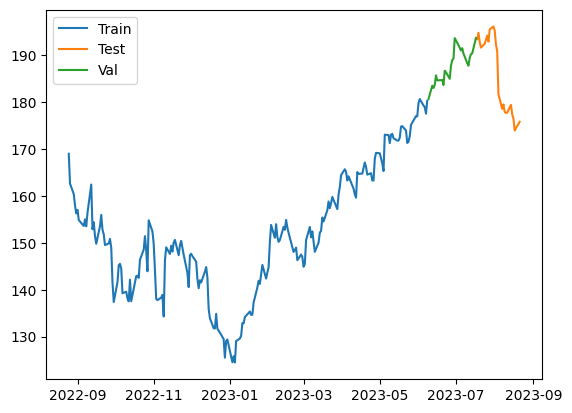

In [79]:
q_80 = int(len(dates) * 0.80)
q_90 = int(len(dates)*0.9)
dates_train, x_train, y_train = dates[:q_80], x[:q_80], y[:q_80]
dates_val, x_val, y_val = dates[q_80:q_90], x[q_80:q_90], y[q_80:q_90]
dates_test, x_test, y_test = dates[q_90:], x[q_90:], y[q_90:]

plt.plot(dates_train,y_train, label = 'Train')

plt.plot(dates_test,y_test, label = 'Test')

plt.plot(dates_val,y_val, label = "Val")
plt.legend()

In [81]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


model = Sequential([layers.Input((3,1)), layers.LSTM(64), layers.Dense(32, activation = 'relu'), layers.Dense(32, activation = 'relu'),  layers.Dense(1)])

model.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.001), metrics = ['mean_absolute_error'])
model.save_weights('model.h5')

model.fit(x_train, y_train, validation_data= (x_val, y_val), epochs = 100)

Epoch 1/100
7/7 [==============================] - 3s 97ms/step - loss: 23475.5371 - mean_absolute_error: 152.6533 - val_loss: 35384.0312 - val_mean_absolute_error: 188.0746
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 23251.8438 - mean_absolute_error: 151.9193 - val_loss: 35124.7266 - val_mean_absolute_error: 187.3839
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 23058.5918 - mean_absolute_error: 151.2817 - val_loss: 34895.3633 - val_mean_absolute_error: 186.7710
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 22872.5605 - mean_absolute_error: 150.6667 - val_loss: 34669.9336 - val_mean_absolute_error: 186.1665
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 22690.0449 - mean_absolute_error: 150.0591 - val_loss: 34407.4805 - val_mean_absolute_error: 185.4603
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 22446.4023 - mean_absolute_error: 149.2435 - val_loss: 340

7/7 [==============================] - 1s 3ms/step


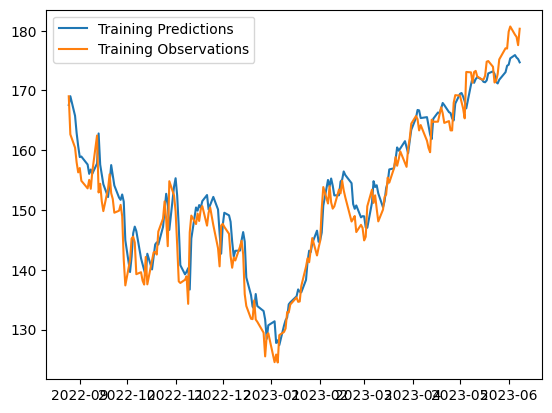

In [82]:
train_predictions = model.predict(x_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 22ms/step


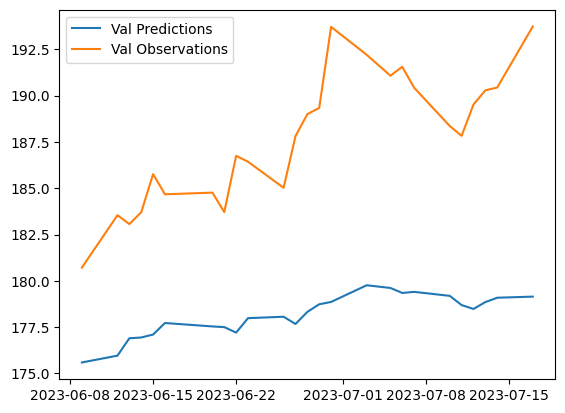

In [83]:
val_predictions = model.predict(x_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Val Predictions', 'Val Observations'])

1/1 [==============================] - 0s 24ms/step


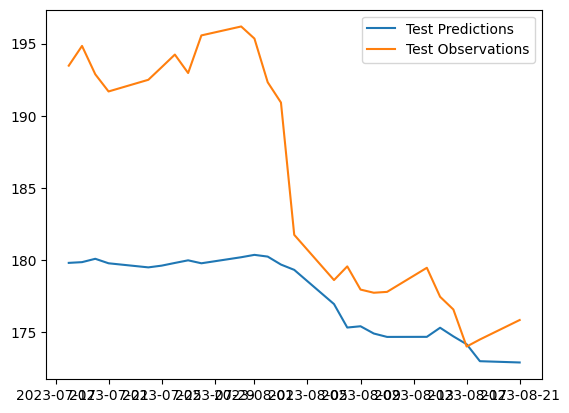

In [84]:
test_predictions = model.predict(x_test).flatten()
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])

In [85]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val,dates_test])
last_window = deepcopy(x_train[-1])

for target_date in recursive_dates:
  next = model.predict(np.array([last_window[-3:]])).flatten()
  recursive_predictions.append(next)
  last_window= np.concatenate((last_window,[next]))


print(recursive_predictions)


1/1 [==============================] - 0s 25ms/step
[array([174.70778], dtype=float32), array([173.40173], dtype=float32), array([172.49303], dtype=float32), array([171.90355], dtype=float32), array([171.49602], dtype=float32), array([171.21269], dtype=float32), array([171.01254], dtype=float32), array([170.87018], dtype=float32), array([170.76823], dtype=float32), array([170.69496], dtype=float32), array([170.64215], dtype=float32), array([170.60402], dtype=float32), array([170.5764], dtype=float32), array([170.55641], dtype=float32), array([170.5419], dtype=float32), array([170.53137], dtype=float32), array([170.52373], dtype=float32), array([170.5182], dtype=float32), array([170.51419], dtype=float32), array([170.51128], dtype=float32), array([170.50917], dtype=float32), array([170.50761], dtype=float32), array([170.50648], dtype=float32), array([170.50568], dtype=float32), array([170.5051], dtype=float32), array([170.50468], dtype=float32), array([170.50436], dtype=float32), array(

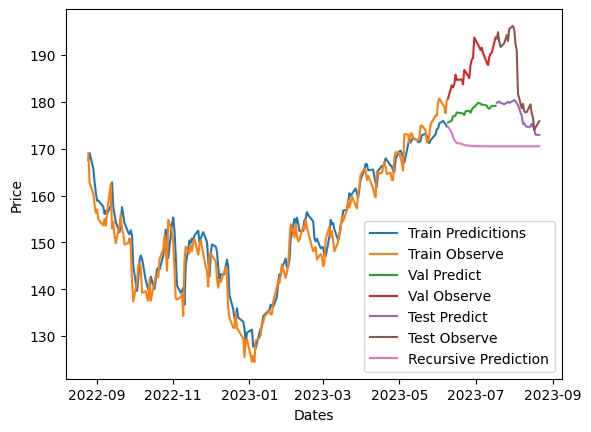

In [86]:
from datetime import date
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.legend(['Train Predicitions', 'Train Observe','Val Predict', 'Val Observe', 'Test Predict', 'Test Observe', 'Recursive Prediction'])


Using a normal distribution to predict Stock Returns


Text(0, 0.5, 'Bin Count')

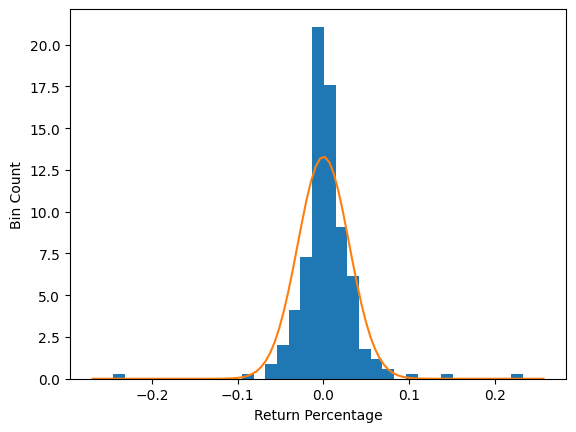

In [88]:
from scipy.stats import norm

plt.hist(df2['Stock Return'], bins = 35, density = True)
mean, std = norm.fit(df2['Stock Return'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, np.round(mean,2), np.round(std,2))
plt.plot(x, y, label = 'Normal PDF')

plt.xlabel('Return Percentage')
plt.ylabel('Bin Count')


#As shown the normal distribution is a good fit for stock returns


Picking 5 Stocks based on Expected Values of the Returns

In [20]:
def selectStock_Returns(stockList):

  finList = []
  means = []
  for i in stockList:
    stockInfo= yf.Ticker(i).history(period = '1y')
    stockInfo = stockInfo.reset_index()
    stockInfo = stockInfo[['Date', 'Close']]
    df = stockInfo['Close'].pct_change()
    df = df.reset_index()
    df.drop(index=df.index[0], axis=0, inplace=True)
    df = df.rename(columns={"Close": "Stock Return"})
    returnMean = np.mean(df['Stock Return'])
    if len(finList) < 5:
      finList.append(i)
      means.append(returnMean)
    elif returnMean > np.min(means):
      a = means.index(np.min(means))
      means[a] = returnMean
      finList[a] = i

  return finList, means


In [21]:
print(selectStock_Returns(myList))

(['MAR', 'TT', 'ORCL', 'FCX', 'AMAT'], [0.0011435844534595137, 0.0010848269605386652, 0.001885359793868845, 0.0014968329608911356, 0.001932729850569696])



Selecting 5 Stocks based on LSTM predictions





In [22]:

from datetime import timedelta

startDate = date.today()
change = timedelta(days = 30)
endDate = startDate + change
futureDates = []

while startDate <= endDate:
  futureDates.append(startDate)

  startDate += timedelta(days = 1)


def train_stock_model(stock_symbol, x_train, y_train, x_val, y_val):
    model = Sequential([layers.Input((3, 1)), layers.LSTM(64), layers.Dense(32, activation='relu'),
                        layers.Dense(32, activation='relu'), layers.Dense(1)])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)
    return model


def make_recursive_predictions(model, x_val, future_dates):
    recursive_predictions = []
    last_window = deepcopy(x_val[-1])

    for _ in range(len(future_dates)):
        next = model.predict(np.array([last_window[-3:]])).flatten()
        recursive_predictions.append(next)
        last_window = np.concatenate((last_window, [next]))

    return recursive_predictions



def predict_future_stock_prices(stock_list, future_dates):
    predictions = []

    for symbol in stock_list:
        stock_info = yf.Ticker(symbol)
        hist = stock_info.history(period='1y')
        hist = hist.reset_index()
        df = hist[['Date', 'Close']]
        df['Date'] = pd.to_datetime(df['Date']).dt.date
        df.index = df.pop('Date')

        windowedDF = createWindowedDF_Prices(df)
        windowedDF = windowedDF.reset_index()

        dates, x, y = windowToDateXY(windowedDF)

        q_85 = int(len(dates) * 0.85)
        dates_train, x_train, y_train = dates[:q_85], x[:q_85], y[:q_85]
        dates_val, x_val, y_val = dates[q_85:], x[q_85:], y[q_85:]

        model = train_stock_model(symbol, x_train, y_train, x_val, y_val)

        recursive_predictions = make_recursive_predictions(model, x_val, future_dates)

        predictions.append(recursive_predictions)

    return predictions


def selectStocks_Prices(LIST,future_dates):
  modelPredictions = []
  count = 0
  finList = []
  bestPrices = []
  futurePredictions = predict_future_stock_prices(LIST, future_dates)

  for i in LIST:
    df = yf.Ticker(i).history(period = '5d')
    percentIncrease = (futurePredictions[count][-1])/ (df['Close'].iloc[-1])

    if len(finList) < 5:
      finList.append(i)
      bestPrices.append(percentIncrease)
      modelPredictions.append(futurePredictions[count])

    elif percentIncrease > np.min(bestPrices):
      a = bestPrices.index(np.min(bestPrices))
      finList[a] = i
      bestPrices[a] = percentIncrease
      modelPredictions[a] = futurePredictions[count]

    count+=1

  return finList, bestPrices, modelPredictions




In [89]:

LSTMList,Increases,LSTMPredictions = selectStocks_Prices(myList,futureDates)

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 3s 102ms/step - loss: 783.4724 - mean_absolute_error: 27.8884 - val_loss: 1065.5358 - val_mean_absolute_error: 32.6239
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 734.5436 - mean_absolute_error: 26.9925 - val_loss: 1006.2474 - val_mean_absolute_error: 31.7020
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 679.4347 - mean_absolute_error: 25.9484 - val_loss: 933.8441 - val_mean_absolute_error: 30.5385
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 608.8872 - mean_absolute_error: 24.5443 - val_loss: 838.1697 - val_mean_absolute_error: 28.9291
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 517.4847 - mean_absolute_error: 22.5996 - val_loss: 714.9807 - val_mean_absolute_error: 26.7144
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 399.8230 - mean_absolute_error: 19.8243 - val_loss: 550.4848 - val_mean_absolute_error

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 4s 180ms/step - loss: 29070.0293 - mean_absolute_error: 170.0350 - val_loss: 38616.5117 - val_mean_absolute_error: 196.4387
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 28857.6562 - mean_absolute_error: 169.4064 - val_loss: 38310.2969 - val_mean_absolute_error: 195.6577
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 28564.6719 - mean_absolute_error: 168.5443 - val_loss: 37946.9414 - val_mean_absolute_error: 194.7270
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 28226.8184 - mean_absolute_error: 167.5349 - val_loss: 37498.1992 - val_mean_absolute_error: 193.5712
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 27787.1172 - mean_absolute_error: 166.2176 - val_loss: 36888.8359 - val_mean_absolute_error: 191.9907
Epoch 6/100
7/7 [==============================] - 0s 15ms/step - loss: 27167.0527 - mean_absolute_error: 164.3388 - val_loss: 36

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 3s 98ms/step - loss: 7499.9883 - mean_absolute_error: 85.5149 - val_loss: 13421.4854 - val_mean_absolute_error: 115.8375
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 7398.9624 - mean_absolute_error: 84.9234 - val_loss: 13308.0625 - val_mean_absolute_error: 115.3469
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 7328.0605 - mean_absolute_error: 84.5059 - val_loss: 13207.1133 - val_mean_absolute_error: 114.9085
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 7242.5234 - mean_absolute_error: 84.0011 - val_loss: 13077.5791 - val_mean_absolute_error: 114.3435
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 7133.0786 - mean_absolute_error: 83.3422 - val_loss: 12908.2285 - val_mean_absolute_error: 113.6005
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 6993.5024 - mean_absolute_error: 82.4969 - val_loss: 12705.8652 - va

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 3s 96ms/step - loss: 5847.4106 - mean_absolute_error: 76.3843 - val_loss: 7889.7104 - val_mean_absolute_error: 88.7474
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 5777.3013 - mean_absolute_error: 75.9240 - val_loss: 7806.1055 - val_mean_absolute_error: 88.2749
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 5697.1470 - mean_absolute_error: 75.3928 - val_loss: 7693.8569 - val_mean_absolute_error: 87.6368
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 5589.7510 - mean_absolute_error: 74.6787 - val_loss: 7547.8989 - val_mean_absolute_error: 86.8002
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 5453.5698 - mean_absolute_error: 73.7578 - val_loss: 7367.5312 - val_mean_absolute_error: 85.7550
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 5291.1660 - mean_absolute_error: 72.6478 - val_loss: 7158.5361 - val_mean_abso

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 3s 95ms/step - loss: 11933.7402 - mean_absolute_error: 108.0412 - val_loss: 20358.7031 - val_mean_absolute_error: 142.6133
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 11825.3711 - mean_absolute_error: 107.5388 - val_loss: 20213.9414 - val_mean_absolute_error: 142.1048
Epoch 3/100
7/7 [==============================] - 0s 13ms/step - loss: 11707.3799 - mean_absolute_error: 106.9878 - val_loss: 20036.1641 - val_mean_absolute_error: 141.4780
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 11555.6016 - mean_absolute_error: 106.2723 - val_loss: 19804.6270 - val_mean_absolute_error: 140.6572
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 11358.8838 - mean_absolute_error: 105.3441 - val_loss: 19507.2363 - val_mean_absolute_error: 139.5961
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 11124.7139 - mean_absolute_error: 104.2263 - val_loss: 191

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 3s 102ms/step - loss: 87858.7422 - mean_absolute_error: 295.9696 - val_loss: 103393.3984 - val_mean_absolute_error: 321.4176
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 87618.9922 - mean_absolute_error: 295.5641 - val_loss: 103190.1562 - val_mean_absolute_error: 321.1013
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 87427.9922 - mean_absolute_error: 295.2410 - val_loss: 102954.5000 - val_mean_absolute_error: 320.7342
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 87161.2344 - mean_absolute_error: 294.7881 - val_loss: 102592.1406 - val_mean_absolute_error: 320.1688
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 86822.7969 - mean_absolute_error: 294.2136 - val_loss: 102207.9375 - val_mean_absolute_error: 319.5682
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 86441.1562 - mean_absolute_error: 293.5644 - val_los

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 5s 144ms/step - loss: 56435.9609 - mean_absolute_error: 236.9579 - val_loss: 54743.2305 - val_mean_absolute_error: 233.7525
Epoch 2/100
7/7 [==============================] - 0s 20ms/step - loss: 56217.1289 - mean_absolute_error: 236.4941 - val_loss: 54522.9961 - val_mean_absolute_error: 233.2808
Epoch 3/100
7/7 [==============================] - 0s 21ms/step - loss: 55976.4102 - mean_absolute_error: 235.9854 - val_loss: 54249.5625 - val_mean_absolute_error: 232.6941
Epoch 4/100
7/7 [==============================] - 0s 17ms/step - loss: 55660.3906 - mean_absolute_error: 235.3165 - val_loss: 53881.8633 - val_mean_absolute_error: 231.9026
Epoch 5/100
7/7 [==============================] - 0s 21ms/step - loss: 55253.0703 - mean_absolute_error: 234.4485 - val_loss: 53416.7422 - val_mean_absolute_error: 230.8976
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 54736.9609 - mean_absolute_error: 233.3447 - val_loss: 52

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 3s 93ms/step - loss: 4208.2148 - mean_absolute_error: 64.8120 - val_loss: 5635.4800 - val_mean_absolute_error: 75.0364
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 4123.2847 - mean_absolute_error: 64.1525 - val_loss: 5534.6934 - val_mean_absolute_error: 74.3617
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 4027.8889 - mean_absolute_error: 63.4046 - val_loss: 5415.3105 - val_mean_absolute_error: 73.5545
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 3919.3315 - mean_absolute_error: 62.5425 - val_loss: 5271.0713 - val_mean_absolute_error: 72.5674
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 3777.7024 - mean_absolute_error: 61.3986 - val_loss: 5075.9248 - val_mean_absolute_error: 71.2099
Epoch 6/100
7/7 [==============================] - 0s 15ms/step - loss: 3582.4575 - mean_absolute_error: 59.7866 - val_loss: 4803.0332 - val_mean_abso

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 4s 149ms/step - loss: 1341.8735 - mean_absolute_error: 36.2978 - val_loss: 1617.7734 - val_mean_absolute_error: 40.1819
Epoch 2/100
7/7 [==============================] - 0s 22ms/step - loss: 1288.8995 - mean_absolute_error: 35.5543 - val_loss: 1557.2461 - val_mean_absolute_error: 39.4213
Epoch 3/100
7/7 [==============================] - 0s 17ms/step - loss: 1226.3018 - mean_absolute_error: 34.6569 - val_loss: 1474.2521 - val_mean_absolute_error: 38.3538
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 1143.9230 - mean_absolute_error: 33.4420 - val_loss: 1370.2577 - val_mean_absolute_error: 36.9726
Epoch 5/100
7/7 [==============================] - 0s 17ms/step - loss: 1037.9850 - mean_absolute_error: 31.8151 - val_loss: 1232.3369 - val_mean_absolute_error: 35.0569
Epoch 6/100
7/7 [==============================] - 0s 15ms/step - loss: 898.1403 - mean_absolute_error: 29.5228 - val_loss: 1047.0927 - val_mean_abso

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 3s 95ms/step - loss: 16783.3926 - mean_absolute_error: 129.2725 - val_loss: 14481.8154 - val_mean_absolute_error: 120.2456
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 16603.3633 - mean_absolute_error: 128.5748 - val_loss: 14306.4014 - val_mean_absolute_error: 119.5140
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 16409.1836 - mean_absolute_error: 127.8180 - val_loss: 14106.2695 - val_mean_absolute_error: 118.6736
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 16175.3369 - mean_absolute_error: 126.8993 - val_loss: 13852.1953 - val_mean_absolute_error: 117.5981
Epoch 5/100
7/7 [==============================] - 0s 10ms/step - loss: 15872.5127 - mean_absolute_error: 125.6970 - val_loss: 13508.2910 - val_mean_absolute_error: 116.1260
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 15449.5234 - mean_absolute_error: 124.0034 - val_loss: 129

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 3s 96ms/step - loss: 26033.8477 - mean_absolute_error: 160.9517 - val_loss: 37798.6992 - val_mean_absolute_error: 194.2252
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 25805.3008 - mean_absolute_error: 160.2418 - val_loss: 37506.4414 - val_mean_absolute_error: 193.4712
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 25530.1016 - mean_absolute_error: 159.3777 - val_loss: 37109.3750 - val_mean_absolute_error: 192.4422
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 25152.4863 - mean_absolute_error: 158.1898 - val_loss: 36562.6172 - val_mean_absolute_error: 191.0165
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 24673.4688 - mean_absolute_error: 156.6665 - val_loss: 35927.5781 - val_mean_absolute_error: 189.3469
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 24096.7637 - mean_absolute_error: 154.8145 - val_loss: 351

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 6s 164ms/step - loss: 40413.5703 - mean_absolute_error: 200.8245 - val_loss: 47628.2695 - val_mean_absolute_error: 217.9636
Epoch 2/100
7/7 [==============================] - 0s 20ms/step - loss: 40147.5664 - mean_absolute_error: 200.1597 - val_loss: 47363.3828 - val_mean_absolute_error: 217.3550
Epoch 3/100
7/7 [==============================] - 0s 16ms/step - loss: 39897.7148 - mean_absolute_error: 199.5356 - val_loss: 47075.4688 - val_mean_absolute_error: 216.6918
Epoch 4/100
7/7 [==============================] - 0s 24ms/step - loss: 39618.3398 - mean_absolute_error: 198.8342 - val_loss: 46743.6875 - val_mean_absolute_error: 215.9247
Epoch 5/100
7/7 [==============================] - 0s 21ms/step - loss: 39284.4922 - mean_absolute_error: 197.9918 - val_loss: 46327.3438 - val_mean_absolute_error: 214.9580
Epoch 6/100
7/7 [==============================] - 0s 22ms/step - loss: 38834.9414 - mean_absolute_error: 196.8540 - val_loss: 45

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 4s 104ms/step - loss: 92231.8438 - mean_absolute_error: 303.1389 - val_loss: 108368.7812 - val_mean_absolute_error: 329.0525
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 91982.9297 - mean_absolute_error: 302.7276 - val_loss: 108093.5234 - val_mean_absolute_error: 328.6339
Epoch 3/100
7/7 [==============================] - 0s 25ms/step - loss: 91695.0469 - mean_absolute_error: 302.2516 - val_loss: 107704.8594 - val_mean_absolute_error: 328.0421
Epoch 4/100
7/7 [==============================] - 0s 17ms/step - loss: 91315.8125 - mean_absolute_error: 301.6242 - val_loss: 107268.1484 - val_mean_absolute_error: 327.3758
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 90885.9844 - mean_absolute_error: 300.9111 - val_loss: 106744.0859 - val_mean_absolute_error: 326.5743
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 90329.4219 - mean_absolute_error: 299.9849 - val_los

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 4s 98ms/step - loss: 59058.9375 - mean_absolute_error: 242.7190 - val_loss: 72500.0625 - val_mean_absolute_error: 269.0747
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 58806.7109 - mean_absolute_error: 242.1984 - val_loss: 72178.9844 - val_mean_absolute_error: 268.4774
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 58498.0859 - mean_absolute_error: 241.5605 - val_loss: 71809.6562 - val_mean_absolute_error: 267.7888
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 58141.3438 - mean_absolute_error: 240.8210 - val_loss: 71366.5234 - val_mean_absolute_error: 266.9601
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 57711.6328 - mean_absolute_error: 239.9279 - val_loss: 70841.1250 - val_mean_absolute_error: 265.9740
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 57176.0898 - mean_absolute_error: 238.8062 - val_loss: 701

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 3s 99ms/step - loss: 1838.6549 - mean_absolute_error: 42.7663 - val_loss: 1540.2054 - val_mean_absolute_error: 39.2384
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 1778.1956 - mean_absolute_error: 42.0522 - val_loss: 1483.6488 - val_mean_absolute_error: 38.5109
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 1708.6769 - mean_absolute_error: 41.2142 - val_loss: 1402.1993 - val_mean_absolute_error: 37.4384
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 1609.0814 - mean_absolute_error: 39.9882 - val_loss: 1289.2694 - val_mean_absolute_error: 35.8985
Epoch 5/100
7/7 [==============================] - 0s 10ms/step - loss: 1472.1067 - mean_absolute_error: 38.2332 - val_loss: 1134.9751 - val_mean_absolute_error: 33.6808
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 1285.3831 - mean_absolute_error: 35.6949 - val_loss: 929.3859 - val_mean_absol

[1.010182]


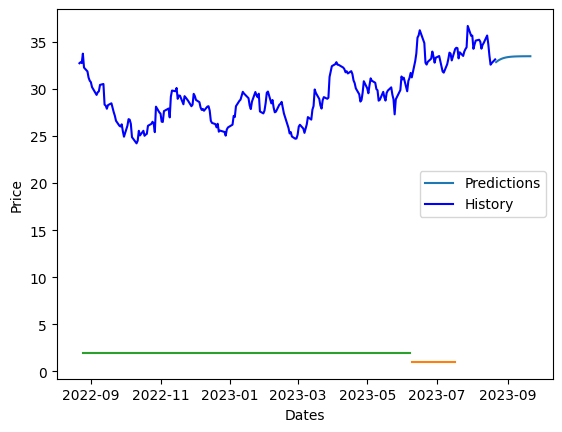

In [91]:
index = 0

hist = yf.Ticker(LSTMList[index]).history(period = '1y')
print(Increases[index])

plt.plot(futureDates, LSTMPredictions[index], label = 'Predictions')
plt.plot(hist['Close'], color = 'blue', label = 'History')


plt.plot(dates_val,np.linspace(1,1,len(dates_val)))
plt.plot(dates_train, np.linspace(2,2,len(dates_train)))

plt.ylabel('Price')
plt.xlabel('Dates')
plt.legend()


In [52]:
print(LSTMList)

['INTC', 'RVTY', 'ORCL', 'HRL', 'FCX']


In [54]:
myPortfolio = ['AMAT', 'LPX','PLTR','TSLA','VOO','VTWO','XLF']
myPredictions = predict_future_stock_prices(myPortfolio, futureDates)

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 7s 793ms/step - loss: 11959.7432 - mean_absolute_error: 108.1610 - val_loss: 20391.8164 - val_mean_absolute_error: 142.7294
Epoch 2/100
7/7 [==============================] - 0s 19ms/step - loss: 11861.6953 - mean_absolute_error: 107.7102 - val_loss: 20282.1621 - val_mean_absolute_error: 142.3447
Epoch 3/100
7/7 [==============================] - 0s 17ms/step - loss: 11777.1680 - mean_absolute_error: 107.3163 - val_loss: 20166.6406 - val_mean_absolute_error: 141.9383
Epoch 4/100
7/7 [==============================] - 0s 19ms/step - loss: 11678.5117 - mean_absolute_error: 106.8515 - val_loss: 20030.7832 - val_mean_absolute_error: 141.4588
Epoch 5/100
7/7 [==============================] - 0s 23ms/step - loss: 11550.4111 - mean_absolute_error: 106.2490 - val_loss: 19827.5586 - val_mean_absolute_error: 140.7386
Epoch 6/100
7/7 [==============================] - 0s 17ms/step - loss: 11362.8457 - mean_absolute_error: 105.3605 - val_loss: 19

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 5s 105ms/step - loss: 3442.0435 - mean_absolute_error: 58.4628 - val_loss: 4941.6724 - val_mean_absolute_error: 70.0113
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 3356.3347 - mean_absolute_error: 57.7259 - val_loss: 4825.5908 - val_mean_absolute_error: 69.1770
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 3252.7952 - mean_absolute_error: 56.8211 - val_loss: 4698.6777 - val_mean_absolute_error: 68.2530
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 3142.1594 - mean_absolute_error: 55.8379 - val_loss: 4554.4438 - val_mean_absolute_error: 67.1872
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 3011.2341 - mean_absolute_error: 54.6474 - val_loss: 4379.7319 - val_mean_absolute_error: 65.8716
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 2841.1589 - mean_absolute_error: 53.0629 - val_loss: 4134.9858 - val_mean_abs

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 3s 100ms/step - loss: 66.0649 - mean_absolute_error: 7.7990 - val_loss: 217.6668 - val_mean_absolute_error: 14.6852
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 51.4114 - mean_absolute_error: 6.8133 - val_loss: 183.9229 - val_mean_absolute_error: 13.4875
Epoch 3/100
7/7 [==============================] - 0s 14ms/step - loss: 36.1004 - mean_absolute_error: 5.5830 - val_loss: 145.9414 - val_mean_absolute_error: 11.9963
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 20.2625 - mean_absolute_error: 3.9239 - val_loss: 102.5934 - val_mean_absolute_error: 10.0257
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 8.7451 - mean_absolute_error: 1.8812 - val_loss: 62.7391 - val_mean_absolute_error: 7.7849
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 4.8622 - mean_absolute_error: 1.6318 - val_loss: 40.6344 - val_mean_absolute_error: 6.2038
Epoch 7/1

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 4s 101ms/step - loss: 41688.3984 - mean_absolute_error: 198.7598 - val_loss: 67313.2031 - val_mean_absolute_error: 258.7546
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 41387.8555 - mean_absolute_error: 197.9993 - val_loss: 66881.4219 - val_mean_absolute_error: 257.9189
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 41047.1133 - mean_absolute_error: 197.1282 - val_loss: 66415.3750 - val_mean_absolute_error: 257.0130
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 40607.0078 - mean_absolute_error: 195.9946 - val_loss: 65737.1484 - val_mean_absolute_error: 255.6894
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 39982.2422 - mean_absolute_error: 194.3912 - val_loss: 64735.6992 - val_mean_absolute_error: 253.7219
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 39034.7461 - mean_absolute_error: 191.9233 - val_loss: 63

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 9s 478ms/step - loss: 131933.1406 - mean_absolute_error: 362.8057 - val_loss: 167904.4531 - val_mean_absolute_error: 409.7191
Epoch 2/100
7/7 [==============================] - 0s 23ms/step - loss: 131239.4531 - mean_absolute_error: 361.8466 - val_loss: 167089.9375 - val_mean_absolute_error: 408.7239
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 130552.5391 - mean_absolute_error: 360.8977 - val_loss: 166323.7031 - val_mean_absolute_error: 407.7855
Epoch 4/100
7/7 [==============================] - 0s 17ms/step - loss: 129824.6250 - mean_absolute_error: 359.8889 - val_loss: 165365.3594 - val_mean_absolute_error: 406.6087
Epoch 5/100
7/7 [==============================] - 0s 20ms/step - loss: 128829.4766 - mean_absolute_error: 358.5018 - val_loss: 163993.1250 - val_mean_absolute_error: 404.9178
Epoch 6/100
7/7 [==============================] - 0s 22ms/step - loss: 127511.8750 - mean_absolute_error: 356.6610 - v

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 6s 180ms/step - loss: 5177.6548 - mean_absolute_error: 71.8995 - val_loss: 5915.0688 - val_mean_absolute_error: 76.8880
Epoch 2/100
7/7 [==============================] - 0s 15ms/step - loss: 5121.6348 - mean_absolute_error: 71.5079 - val_loss: 5846.3242 - val_mean_absolute_error: 76.4397
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 5054.0796 - mean_absolute_error: 71.0349 - val_loss: 5765.7490 - val_mean_absolute_error: 75.9108
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 4968.5928 - mean_absolute_error: 70.4298 - val_loss: 5655.5889 - val_mean_absolute_error: 75.1816
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 4850.6006 - mean_absolute_error: 69.5870 - val_loss: 5500.4688 - val_mean_absolute_error: 74.1428
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 4679.5132 - mean_absolute_error: 68.3465 - val_loss: 5273.6577 - val_mean_abs

<ipython-input-22-e5ac3b0b014d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Epoch 1/100
7/7 [==============================] - 4s 113ms/step - loss: 1097.3149 - mean_absolute_error: 33.0825 - val_loss: 1161.8668 - val_mean_absolute_error: 34.0790
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 1059.0315 - mean_absolute_error: 32.4988 - val_loss: 1114.8484 - val_mean_absolute_error: 33.3820
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 1011.8597 - mean_absolute_error: 31.7642 - val_loss: 1064.1803 - val_mean_absolute_error: 32.6143
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 959.3645 - mean_absolute_error: 30.9270 - val_loss: 1001.0281 - val_mean_absolute_error: 31.6312
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 891.0842 - mean_absolute_error: 29.8010 - val_loss: 917.6024 - val_mean_absolute_error: 30.2836
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 799.9826 - mean_absolute_error: 28.2280 - val_loss: 804.6840 - val_mean_absolute